# 프로젝트 - Movielens 영화 SBR

## 프로젝트

저번에 했던 추천시스템을 기반으로 하는 프로젝트입니다. 주어진 데이터셋을 전처리하고 예측 모델을 설계한 후,  모델 개선을 위해서 hyperparameter 조정합니다!


## 루브릭 

1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.

- 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.



2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.

- 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.



3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.


- 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

# Data Preprocess


#### 필요한 라이브러리 이용

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import matplotlib.pyplot as plt

#### 데이터 설명


- 명확한 1회 세션의 SessionID포함하지 않고 있기에 UserID가 SessionID 역할 해야 함

- Rating정보가 포함되어 있음

  -  직전 봤던 영화가 맘에 들었는지 여부 파악
  
  - 비슷한 영화를 더 고르게 함
  
  - 낮은 데이터 처리 고민
  

- Time 항목에는 UTC time가 포함되어 있고, 1970-01-01부터 경과된 초단위 시간이 있습니다.

## Step 1. 데이터의 전처리

1. 항목별 기본 분석

2. session length

3. session time

4. cleaning 작업 진행

+ 주의사항) Session단위로 해석을 어떻게 할 건가!

### 항목별 기본 분석

#### 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
# 유저 수(세션 수)와 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### Session Length (유저별 리뷰 갯수)


In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:

# 평균 리뷰 수
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [7]:

# 리뷰 최소값, 리뷰 최댓값
session_length.min(), session_length.max()

(20, 2314)

In [8]:
# 리뷰 분위수( 0.999%)
session_length.quantile(0.999)

1343.181000000005

In [9]:
# 최다 리뷰자 
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [10]:
# Session length의 분포 확인

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

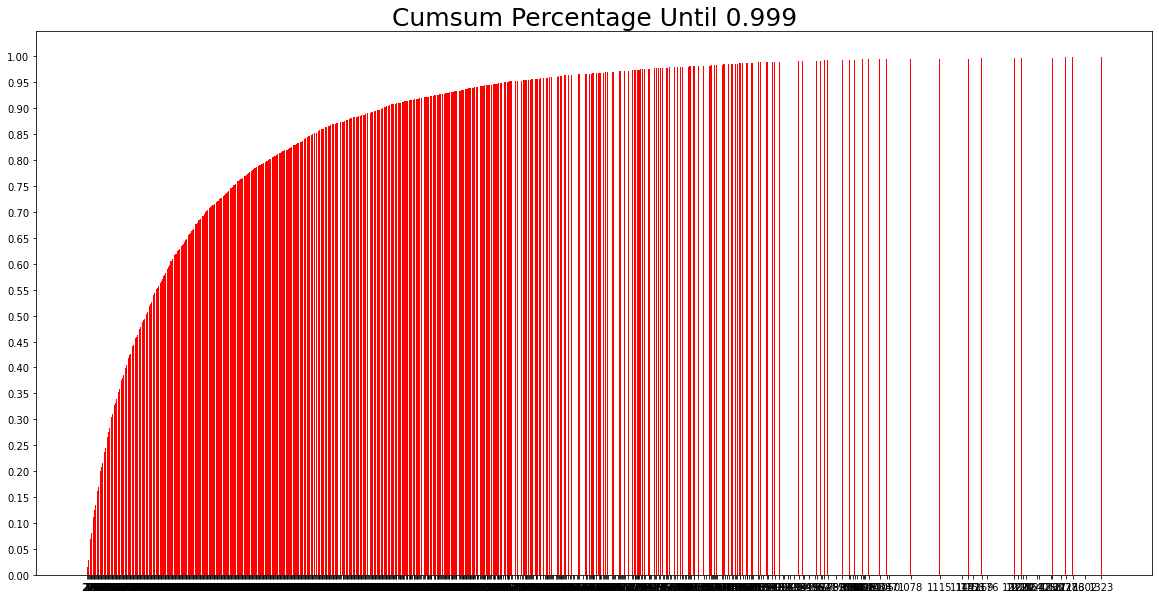

In [11]:
# Session length 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=25)
plt.show()

### Rating

- 이번 실습에서 Rating이 큰 의미를 주지는 못한다고 했으나 실제로 저희가 예측을 하거나 맘에 들었는지 여부 판단을 하려면 이 수치가 중요할 것 같습니다. 그러므로 간단한 데이터 전처리를 하겠습니다.


- Rating에 대한 정보 확인 및 변경

- 최고 점수는 별 다섯 개처럼 평점 5점으로 하겠습니다.

- 평점 5점 기준으로 영화가 맘에 들었는지 여부 판단

- Rating을 통해서 평점이 비슷한 영화를 고를 수 있을 것 같습니다.

- 낮은 데이터 삭제

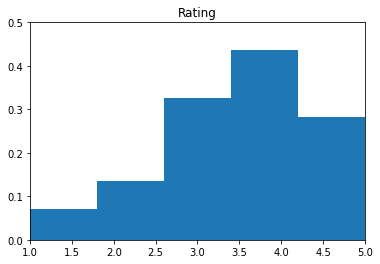

In [12]:
plt.hist(data['Rating'], density=True,bins=5)
plt.title('Rating')
plt.axis([1, 5, 0, 0.5])
plt.show()

그래프를 보아하니 Rating분포가 적은 평점 1,2를 삭제하면 될 것 같습니다

In [13]:

change_Rating = data[data['Rating']>=3]
print(len(change_Rating))

836478


In [14]:

data = data[data['Rating']>=3]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


Rating기준을 이용하여 데이터1000209를  836478로 줄였습니다

### Session Time

-  최근 소비 트렌드 파악 가능.

- 데이터의 시간 정보 확인 및 변경

In [15]:

data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


Time 안에 있는 데이터들을 보았을 때 전혀 무슨 말인지 감이 오지 않습니다. 그러면 우리는 저희가 익숙한 날짜와 시간 패턴인 yyyy-mm-dd hh:mm:ss를 해주면 편할 것 같다는 생각이 듭니다. 노드에 나와있는 방식이 있지만 차라리 datetime라이브러리를 이용하는 것이 더 간편할 것 같습니다


고로, fromtimestamp()이용합니다


https://docs.python.org/ko/3/library/datetime.html

In [16]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


한 눈에 보기 편해졌습니다!!

이제 그러면 데이터가 몇 개월치 있는지에 대해서 확인해보겠습니다


In [17]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


데이터는 2000-04-25 ~ 2003-02-28까지의 데이터가 있다.

### Data Cleansing

- 너무 적게 된 것을 제거해줌

In [18]:

# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [19]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step2. 미니 배치의 구성

- 데이터셋과 미니 배치 구성

- 학습 속도의 최소화 구성 (by Mini-Batch)

- Step 1에서 Session 단위를 어떻게 정의
  
  -> Session-Parallel Mini-Batch 필요 없다.



#### Trian/ Valid/ Test split

- 기준: 기간

- 모델 평가: Valid set 과 Test set


In [21]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date

In [31]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [32]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [33]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 818736
	 Sessions: 6036
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9771
	 Sessions: 390
	 Items: 2348
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7282
	 Sessions: 333
	 Items: 2049
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



#### 좋은 모델 학습을 위해 data나누는 과정

tr, test = split_by_date(data, n_days=90)

tr, val = split_by_date(tr, n_days=90)

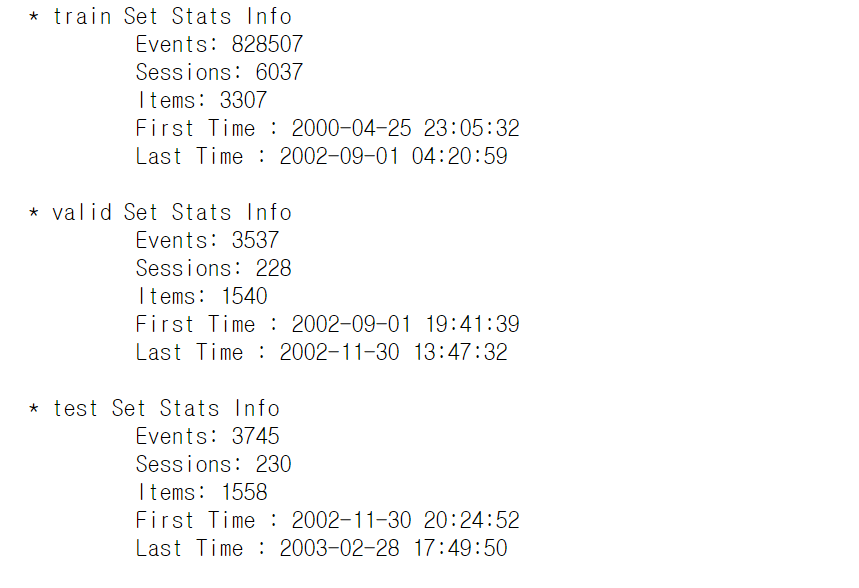

-----------------------------------------------------

tr, test = split_by_date(data, n_days=120)

tr, val = split_by_date(tr, n_days=120)

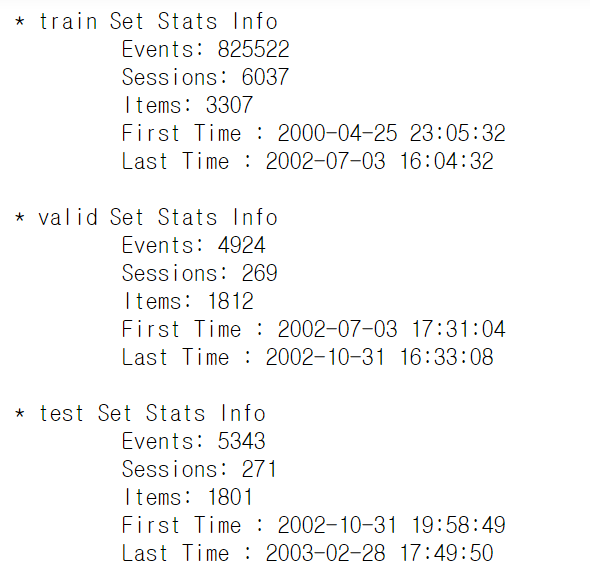


- train set이 너무 크고 valid set이 너무 작아서 제대로 된 결과가 나오지 않을 것 같습니다


-----------------------------------------------------


tr, test = split_by_date(data, n_days=150)

tr, val = split_by_date(tr, n_days=150)

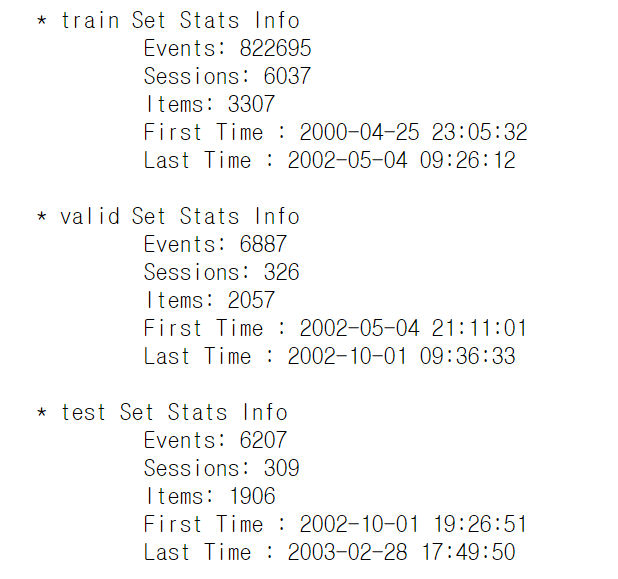

- 위의 두 결과보다는 낫지만 아직 만족할만한 비율은 아니기에 한 번도 올려보겠습니다


----------------------------------------------------

tr, test = split_by_date(data, n_days=180)

tr, val = split_by_date(tr, n_days=180)

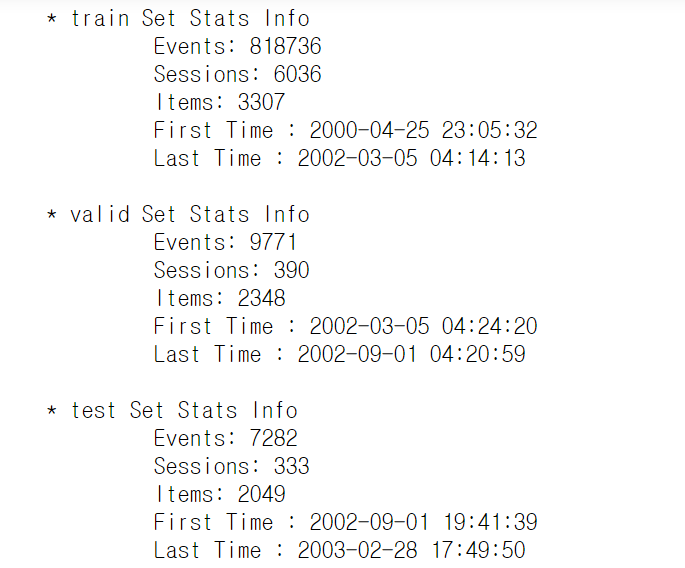

- 이정도면 가장 이상적인 dataset나눔인 것 같아서 더 이상 진행을 하지 않겠습니다.




##### 기본 용어 정리

- Events: 데이터 수

- Sessions: UserId의 값

- Items: ItemId의 값

- First Time: 최소 시간

- Last Time: 최대 시간

In [34]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.

id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [35]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

#### SessionDataset

- 세션이 시작되는 인덱스를 담는 값

- 새로 인덱싱한 값을 갖는 클래스 만들기



In [36]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.

click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.

session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [37]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head()

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4


In [38]:

tr_dataset.click_offsets

array([     0,     53,    169, ..., 818341, 818460, 818736], dtype=int32)

In [39]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6033, 6034, 6035])

In [40]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [41]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(5)
                  

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4


In [42]:

iter_ex = iter(tr_data_loader)

In [44]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### Step 3. 모델 구성

In [45]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [46]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [53]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
#  batch_size를 기존보다 줄여서 학습 속도 줄이기
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [54]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습

In [55]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [56]:

# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.95] 

	 - Recall@20 epoch 1: 0.093290
	 - MRR@20    epoch 1: 0.023686



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.61]

	 - Recall@20 epoch 2: 0.118566
	 - MRR@20    epoch 2: 0.034174



Evaluation:  47%|████▋     | 34/73 [00:26<00:30,  1.29it/s]

	 - Recall@20 epoch 3: 0.125460
	 - MRR@20    epoch 3: 0.036846



### Step 5. 모델 테스트



In [57]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:15<00:26,  1.30it/s]

	 - Recall@20: 0.135547
	 - MRR@20: 0.037852



### Step 6.모델 개선

1. 학습률 변경

2. epochs변경

3. drop_rate 변경

1. 학습률 변경 (10배씩증가)

- Ir = 0.01

- Ir = 0.1

In [58]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.05, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.33] 

	 - Recall@20 epoch 1: 0.129136
	 - MRR@20    epoch 1: 0.037630



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.69]

	 - Recall@20 epoch 2: 0.133042
	 - MRR@20    epoch 2: 0.039020



Evaluation:  47%|████▋     | 34/73 [00:26<00:30,  1.30it/s]

	 - Recall@20 epoch 3: 0.133961
	 - MRR@20    epoch 3: 0.039969



In [59]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:15<00:26,  1.31it/s]

	 - Recall@20: 0.147656
	 - MRR@20: 0.044058



In [60]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.28]

	 - Recall@20 epoch 1: 0.136029
	 - MRR@20    epoch 1: 0.040405



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.3] 

	 - Recall@20 epoch 2: 0.137868
	 - MRR@20    epoch 2: 0.041125



Evaluation:  47%|████▋     | 34/73 [00:26<00:29,  1.30it/s]

	 - Recall@20 epoch 3: 0.138097
	 - MRR@20    epoch 3: 0.040445



In [61]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:15<00:25,  1.31it/s]

	 - Recall@20: 0.149609
	 - MRR@20: 0.046093




-  cs231n에서 배운 바로 하이퍼파라미터 조정할 시 가장 먼저 하는 것은 학습률을 본다고 했기 때문에 가장 먼저 바꾸었지만 눈에 띄게 큰 상향을 보진 못했습니다.

- 정확도와 매트리스 그리고 수치가 전보다 좋지 않게 나왔다

- 배치사이즈  너무 크면 안돌아가고 작으면 텐서가 맞지 않는다고 나온다.

-  위에 시도한 것보다 약간 나아졌다.

-  학습률 0.001, 0.01, 0.1을 비교해봤을 때 0.1의 수치가 가장 좋음. 학습률 증가 시 이득은 있다는 것을 알 수 있습니다.

2. epoch 변경

- epochs = 15

In [62]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.1, epochs=15, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.25]

	 - Recall@20 epoch 1: 0.139476
	 - MRR@20    epoch 1: 0.041073



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.23] 

	 - Recall@20 epoch 2: 0.141774
	 - MRR@20    epoch 2: 0.040890



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.5] 

	 - Recall@20 epoch 3: 0.141544
	 - MRR@20    epoch 3: 0.042072



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.22]

	 - Recall@20 epoch 4: 0.137638
	 - MRR@20    epoch 4: 0.042069



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.25]

	 - Recall@20 epoch 5: 0.140395
	 - MRR@20    epoch 5: 0.041158



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.24]  

	 - Recall@20 epoch 6: 0.139706
	 - MRR@20    epoch 6: 0.040527



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.5]  

	 - Recall@20 epoch 7: 0.140395
	 - MRR@20    epoch 7: 0.040854



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.117, train_loss=5.17] 

	 - Recall@20 epoch 8: 0.140855
	 - MRR@20    epoch 8: 0.040297



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.5] 

	 - Recall@20 epoch 9: 0.142233
	 - MRR@20    epoch 9: 0.041352



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.25]

	 - Recall@20 epoch 10: 0.139936
	 - MRR@20    epoch 10: 0.041126



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.19] 

	 - Recall@20 epoch 11: 0.141314
	 - MRR@20    epoch 11: 0.040201



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.22] 

	 - Recall@20 epoch 12: 0.140395
	 - MRR@20    epoch 12: 0.040900



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.19] 

	 - Recall@20 epoch 13: 0.140165
	 - MRR@20    epoch 13: 0.040655



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.23] 

	 - Recall@20 epoch 14: 0.141085
	 - MRR@20    epoch 14: 0.040604



Evaluation:  47%|████▋     | 34/73 [00:26<00:30,  1.30it/s]

	 - Recall@20 epoch 15: 0.141314
	 - MRR@20    epoch 15: 0.040241



epoch을 늘려도 성능 향상 크게 되지 않은 것을 보아 성능에 큰 영향을 주지는 못하는 것 같습니다.

3. drop_rate 변경

- drop_rate = 0.5

- drop_rate = 0.9

- drop_rate = 1.5

- drop_rate = 0


In [63]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.5, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.2]  

	 - Recall@20 epoch 1: 0.139936
	 - MRR@20    epoch 1: 0.040907



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.23] 

	 - Recall@20 epoch 2: 0.139476
	 - MRR@20    epoch 2: 0.041133



Evaluation:  47%|████▋     | 34/73 [00:26<00:29,  1.30it/s]

	 - Recall@20 epoch 3: 0.140395
	 - MRR@20    epoch 3: 0.041048



In [65]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:15<00:26,  1.30it/s]

	 - Recall@20: 0.142578
	 - MRR@20: 0.042832



In [66]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.9, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.22]  

	 - Recall@20 epoch 1: 0.141544
	 - MRR@20    epoch 1: 0.041142



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.23]

	 - Recall@20 epoch 2: 0.139476
	 - MRR@20    epoch 2: 0.040483



Evaluation:  47%|████▋     | 34/73 [00:26<00:29,  1.31it/s]

	 - Recall@20 epoch 3: 0.139936
	 - MRR@20    epoch 3: 0.040962



In [67]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:15<00:25,  1.31it/s]

	 - Recall@20: 0.147266
	 - MRR@20: 0.042663



In [68]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=1.5, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.17] 

	 - Recall@20 epoch 1: 0.140625
	 - MRR@20    epoch 1: 0.041108



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.23]

	 - Recall@20 epoch 2: 0.140855
	 - MRR@20    epoch 2: 0.041304



Evaluation:  47%|████▋     | 34/73 [00:26<00:29,  1.31it/s]

	 - Recall@20 epoch 3: 0.139936
	 - MRR@20    epoch 3: 0.041557



In [69]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:15<00:25,  1.31it/s]

	 - Recall@20: 0.145313
	 - MRR@20: 0.042283



In [70]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.45] 

	 - Recall@20 epoch 1: 0.140855
	 - MRR@20    epoch 1: 0.041166



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.45] 

	 - Recall@20 epoch 2: 0.139936
	 - MRR@20    epoch 2: 0.040666



Evaluation:  47%|████▋     | 34/73 [00:26<00:29,  1.31it/s]

	 - Recall@20 epoch 3: 0.137408
	 - MRR@20    epoch 3: 0.040590



In [71]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:15<00:26,  1.31it/s]

	 - Recall@20: 0.145313
	 - MRR@20: 0.042264



- 드롭아웃 여부가 크게 반영이 된 것 같지 않지만 그 이유는 epoch수가 너무 적어서 인 것 같습니다.



# 프로젝트 회고

- 학습을 위해서 데이터를 나눠야해서 split_by_date를 여러 번 수정을 했습니다. 근데 경우에 따라 인덱스가 축 방향을 벗어났다는 에러가 떴습니다.

- 구글링 및 질문을  통해서 에러가 떴던 이유는 배치사이즈를 조절하지 않았다는 것을 알게 되어서 수정해보니 더이상 에러가 뜨지 않았습니다.

- 그래서, 제가 배운 것은 배치사이즈가 크면 인덱스가 축 범위를 넘어갈 수 있다 입니다.

- 반대로 너무 작다면 사이즈가 맞지 않게 됩니다.

- 사실 프로젝트는 했지만 Session-based recommendation개념은 여전히 이해가 잘 안 된 것 같습니다. 왜냐하면, 실제 이론적인 부분을 증명하는 코드를 이용했을 때 코드 자체가 이해가 안된 부분이 많았기 때문입니다.

- 그래서, 어느 부분을 수정하고 왜 실행이 안된거지 에러 코드를 이해하는 것과 수정하는 것이 어렵습니다.


